In [118]:
from psycopg2 import connect, extras
import numpy as np
import datetime
import pandas as pd
import glob,os
from matplotlib import pyplot as plt

In [102]:
'''Need to clone chris m's visual behavior code
    located here: https://github.com/mochic/visual_behavior_analysis.git
    Then change path below to point to visual_behavior repo
'''

%cd "C:\Users\svc_ccg\Documents\GitHub\visual_behavior_analysis"
from visual_behavior.translator.foraging2 import data_to_change_detection_core
from visual_behavior.translator.core import create_extended_dataframe

C:\Users\svc_ccg\Documents\GitHub\visual_behavior_analysis


**setup sql connection/cursor to get data from lims**

In [2]:
con = connect(
    dbname='lims2',
    user='limsreader',
    host='limsdb2',
    password='limsro',
    port=5432,
)

con.set_session(
    readonly=True, 
    autocommit=True,
)

cursor = con.cursor(
    cursor_factory=extras.RealDictCursor,
)

In [106]:
def getLimsID(mouse_id):
    query_template = '''
    SELECT * 
    FROM donors d
    WHERE d.external_donor_name = '{}'
    '''

    cursor.execute(query_template.format(mouse_id))
    lims_id = cursor.fetchone()['id']
    return lims_id

def getBehaviorSessionsFromLimsID(lims_id):
    query_template = '''
    SELECT *
    FROM behavior_sessions bs
    WHERE bs.donor_id = {}
    '''

    cursor.execute(query_template.format(lims_id))
    behavior_sessions = pd.DataFrame(cursor.fetchall())
    return behavior_sessions

def getBehaviorSessionsForMouse(mouse_id):
    lims_id = getLimsID(mouse_id)
    return getBehaviorSessionsFromLimsID(lims_id)

def getPicklePath(storage_directory):
    if storage_directory[1] != '/':
        storage_directory = '/' + storage_directory
    pp = glob.glob(os.path.join(storage_directory, '*.pkl'))
    if len(pp)>0:
        return pp[0]
    else:
        return None
    
def getTrialsDF(pklpath):
    core_data = data_to_change_detection_core(pd.read_pickle(pklpath))
    trials = create_extended_dataframe(
            trials=core_data['trials'],
            metadata=core_data['metadata'],
            licks=core_data['licks'],
            time=core_data['time']) 
    return trials

**pull behavior sessions for a given mouse into pandas dataframe**

In [94]:
mouse_id = '461027'
beh_sessions = getBehaviorSessionsForMouse(mouse_id)

#add common rig name
beh_sessions['rig'] = beh_sessions.apply(lambda row: 
        pd.read_sql('select * from equipment where id = {}'.format(row['equipment_id']), con)['name'], axis=1)

#add pkl file paths
beh_sessions['pklfile'] = beh_sessions.apply(lambda row: 
        getPicklePath(row['storage_directory']), axis=1)

In [95]:
#pick out dates to analyze: it takes a bit of time to pull this data from the network, so limiting your
#dates is helpful when possible
startDate = '2019-11-25'
endDate = '2020'
toAnalyze = beh_sessions[(beh_sessions['created_at']>=startDate)&(beh_sessions['created_at']<endDate)]

In [112]:
toAnalyze['trials'] = toAnalyze.apply(lambda row: getTrialsDF(row['pklfile']), axis=1) #this trials object has all the info you need about the session
toAnalyze['stage'] = toAnalyze.apply(lambda row: row['trials']['stage'][0], axis=1) #add the training stage to the dataframe

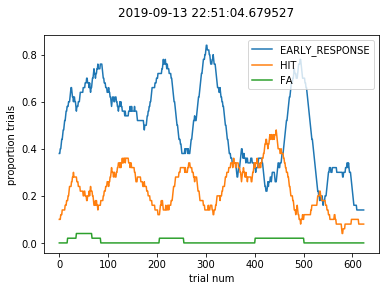

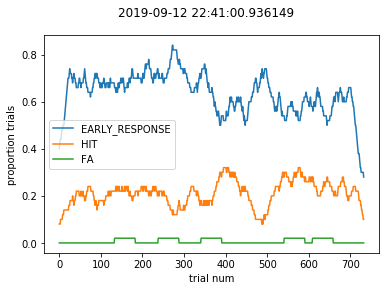

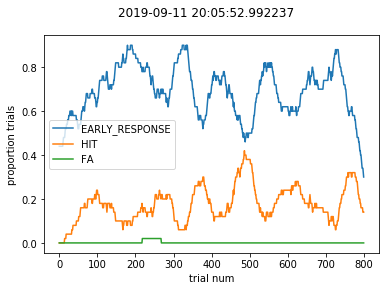

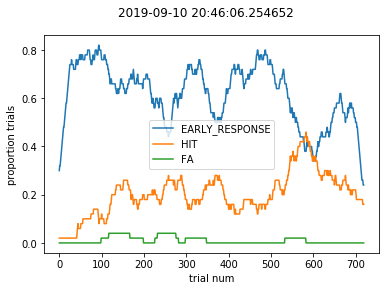

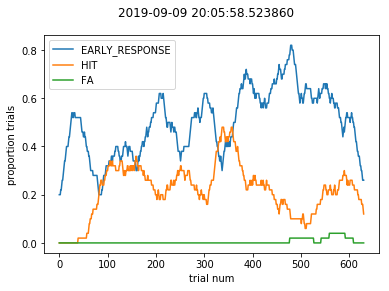

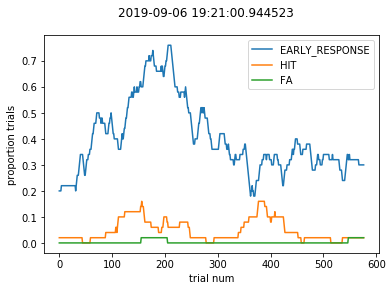

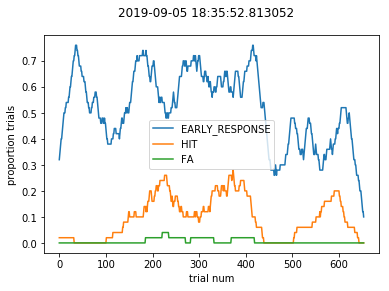

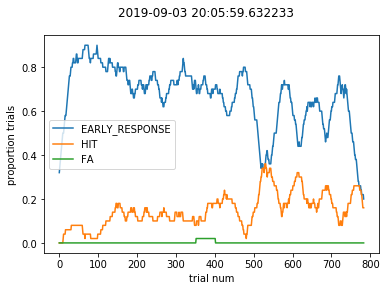

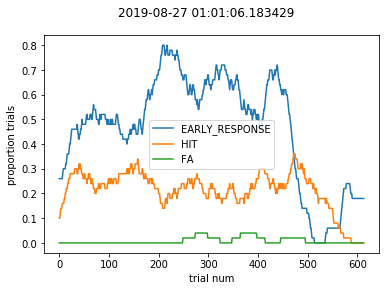

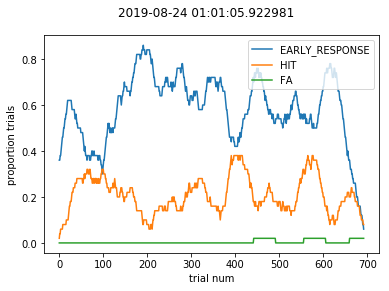

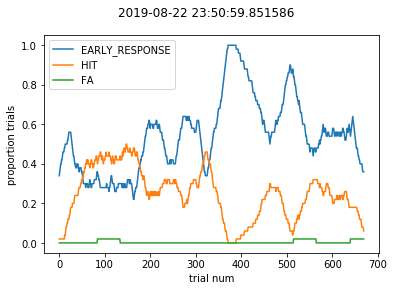

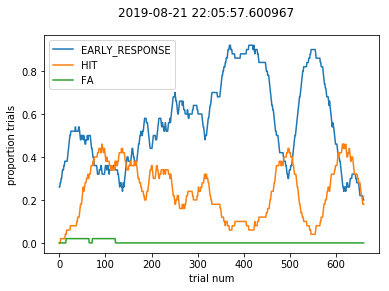

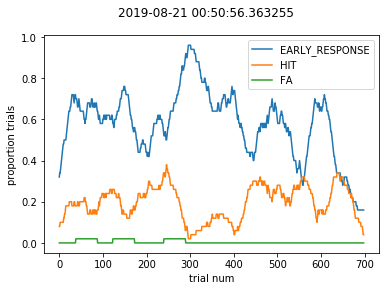

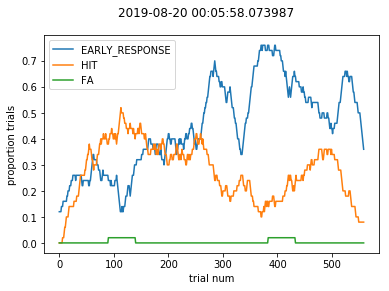

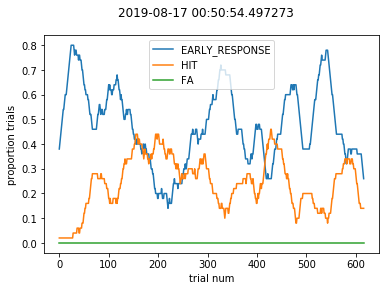

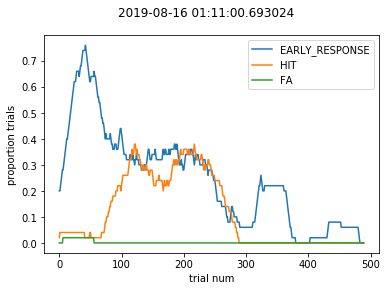

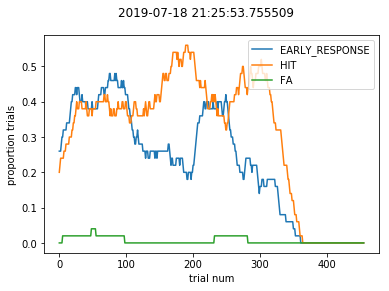

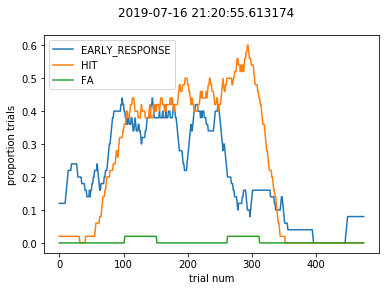

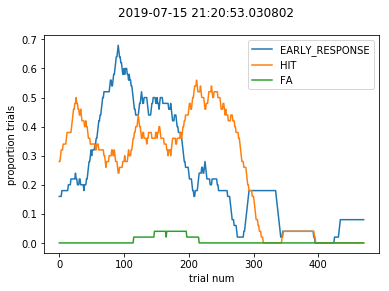

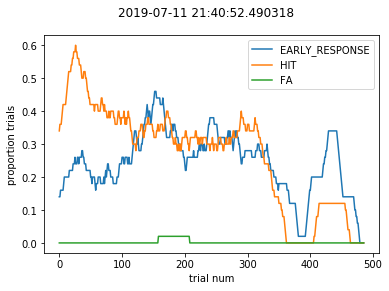

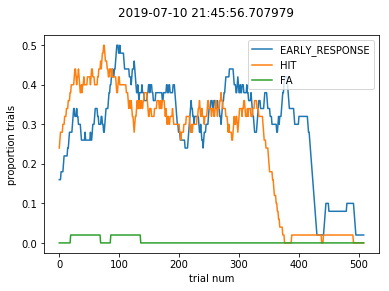

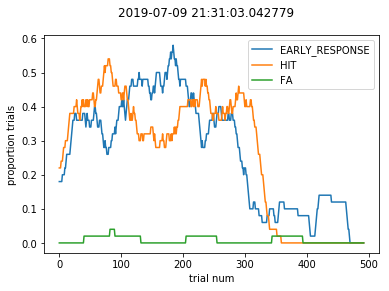

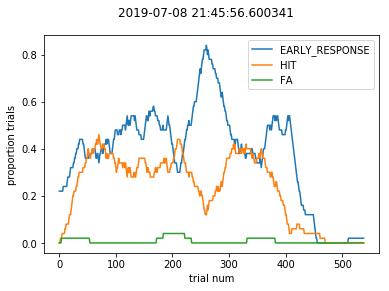

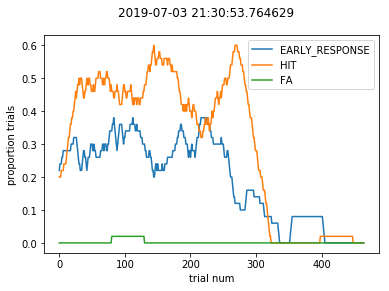

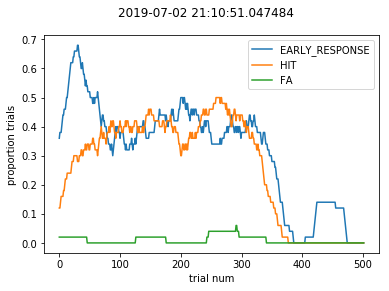

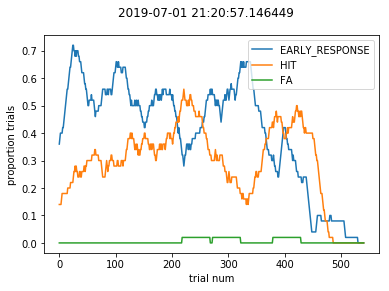

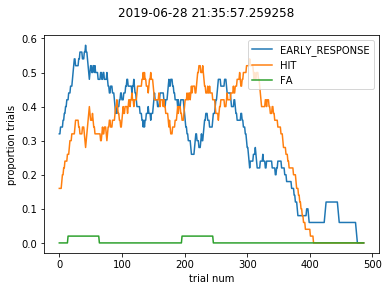

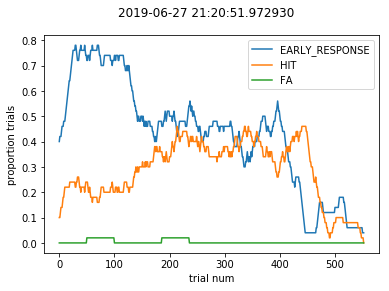

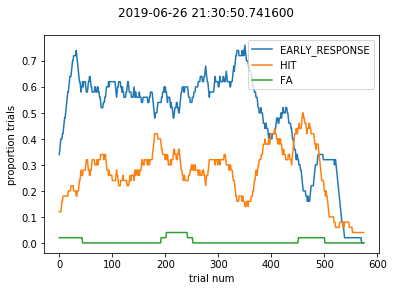

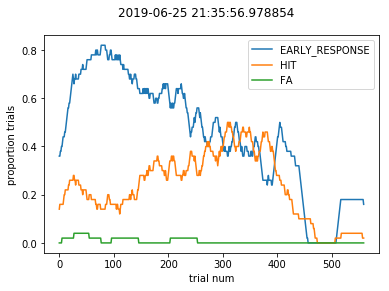

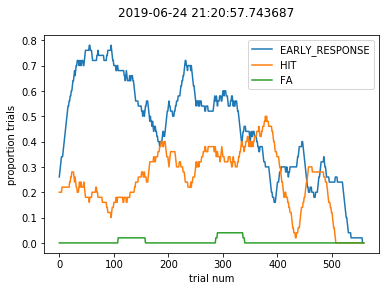

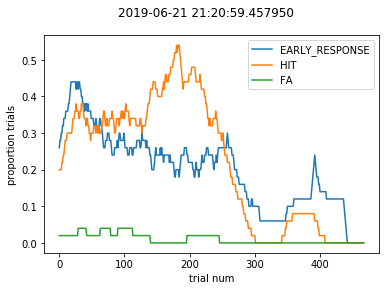

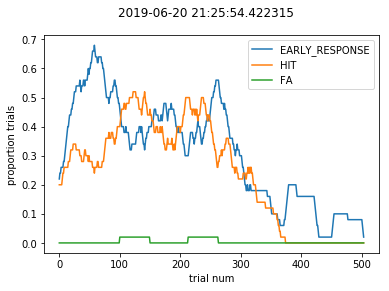

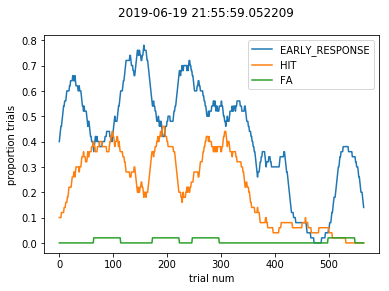

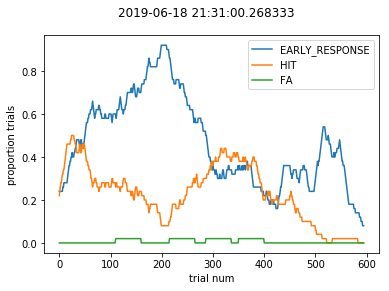

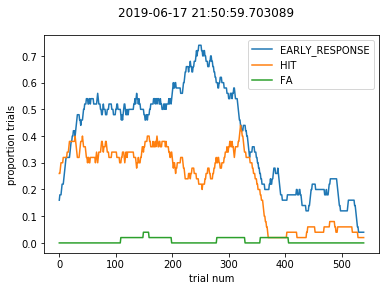

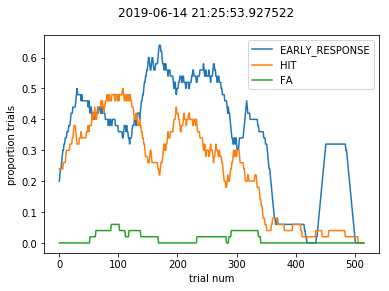

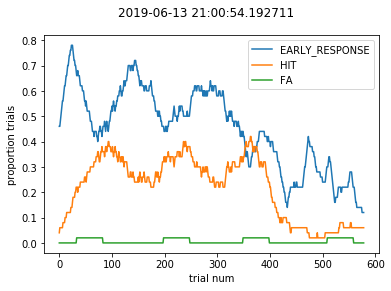

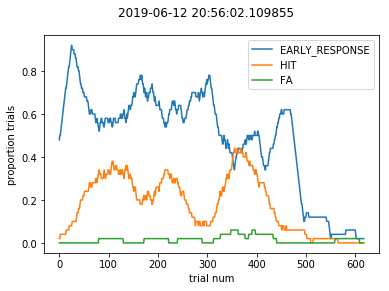

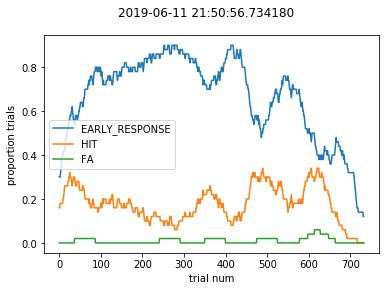

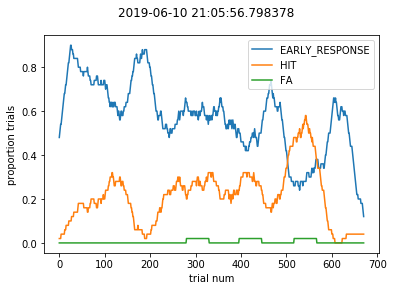

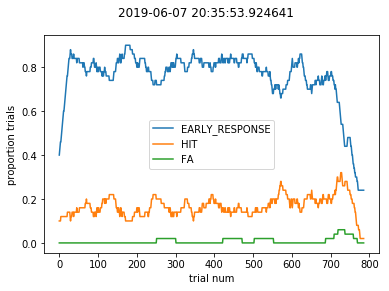

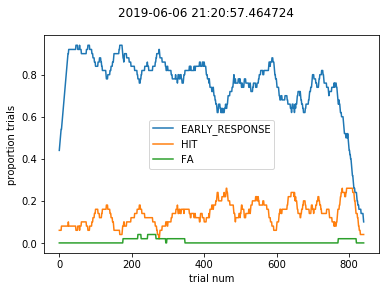

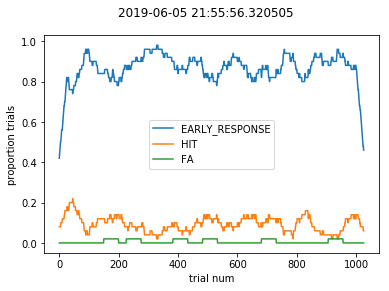

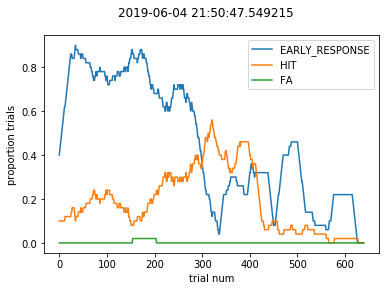

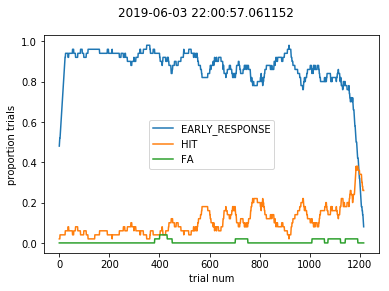

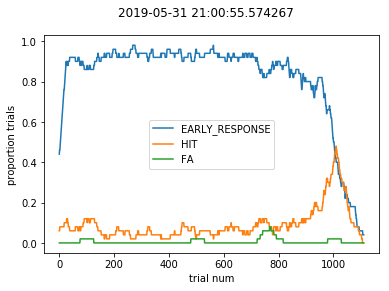

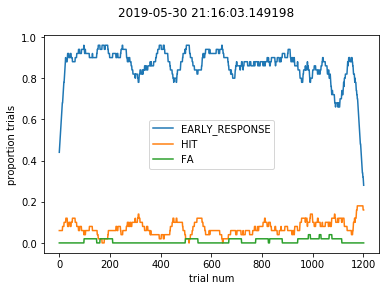

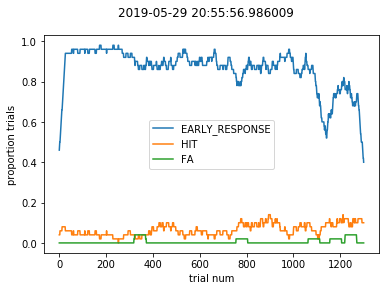

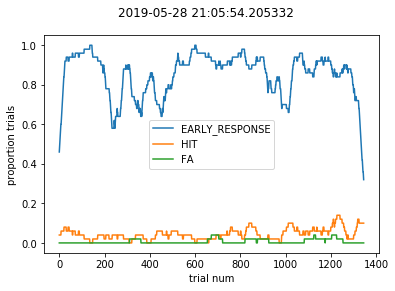

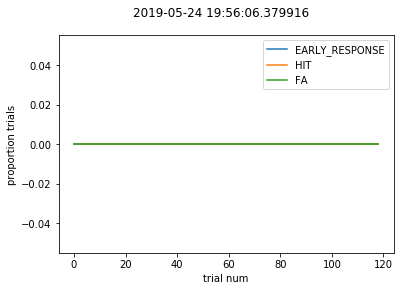

In [127]:
#plot proportion of trials that were aborts, hits and false alarms
for ir, row in toAnalyze.iterrows():
    fig, ax = plt.subplots()
    fig.suptitle(row['created_at'])
    [ax.plot(np.convolve(np.ones(50), row['trials']['response_type']==r, 'same')/50) for r in ['EARLY_RESPONSE', 'HIT', 'FA']]
    ax.set_xlabel('trial num')
    ax.set_ylabel('proportion trials')
    ax.legend(['EARLY_RESPONSE', 'HIT', 'FA'])
    